In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

<div class="float-bar-whh" style="display:block;">
    <center><span class="new-name-whh">D&P - other positions</span></center>
</div>

# Analysize variables.

In [2]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [3]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [4]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 5: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
entries_df#.loc[lambda df:df[26]=='True',[17]]


0     1  2                        3   \
0  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
1  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
2  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
3  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   
4  ed3c50a8-d2d3-3809-9d2a-0f53574560aa  1980  2  Accounting and Auditing   

                   4                      5                    6      7   \
0  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
1  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
2  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
3  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   
4  0.9292892909340925  Industrial Management  0.00825650305491638  Paris   

       8  9   ...     23                  24  25     26 27     28 29 30 31  \
0  France  5  ...  False                           True  5  False            
1  France  5  ...  False                           True     False            
2  France  5  ...  False                          False     False            
3  France  5  ...  False                      54  False     False            
4  France  5  ...  False  paris area, france  54  False     False            

              32  
0  1525765406000  
1  1525765406000  
2  1525765406000  
3  1525765406000  
4  1525765406000  

[5 rows x 33 columns]

In [5]:
# Get an example.
entry = samples_lst[2]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-09-01
[Column 12] True
[Column 13] 2005-06-01
[Column 14] True
[Column 15] False
[Column 16] 273
[Column 17] Financial Controller Assistant,financial controller,assistant
[Column 18] ACCOUNTING
[Column 19] EADS Astrium
[Column 20] EADS Astrium
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] False
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [3]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*7 # "birth_year","gender","skill1","skill2","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['',''] 
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,5,8,9,10]]
        if entry[6] is not None:
            self.profile[3] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
                
        # Then deal with the current entry.
        if self.employment[2] != entry[21]:
            if self.employment[2] in ['D','P']:
                if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                    record.append(self.fired_record())
                else:
                    record.append(self.leave_record(entry[25]))
            self.employment = [None]*7
            if entry[21] in ['D','P']:
                self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[2] = entry[21]
                self.employment[3] = entry[15]
                self.employment[4] = entry[17]
                self.employment[5] = entry[18]
                self.employment[6] = 0
                record.append(self.enter_record())
        else:
            self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
            self.employment[3] = entry[15]
            self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [8]:
# Read, Identify & Aggregate.
empl_file = r"./summary_stats/data/deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        if entry[3] not in ["-1","Accounting and Auditing"] and entry[26] == "False" and not sum([
                            re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
                            for x in ["intern","internship","trainee"]]):
            empl_change_this = career.read(entry)
            if empl_change_this != []:
                empl_changes_lst += empl_change_this

varlist = [
    "type","ticker","yrmth","birth","gender","skill1","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


type ticker   yrmth birth gender                        skill1  \
0        hiring      P  200109  1975      2                         Legal   
1        firing      P  200207  1975      2                         Legal   
2        hiring      P  199602  1973      2           Banking and Finance   
3       leaving      P  200202  1973      2           Banking and Finance   
4        hiring      P  201108  1983      1             Middle Management   
5       leaving      P  201304  1983      1             Middle Management   
6        hiring      P  201201  1972      0      CRM and Sales Management   
7       leaving      P  201208  1972      0      CRM and Sales Management   
8        hiring      D  200106  1976      1                    Recruiting   
9       leaving      D  200305  1976      1                    Recruiting   
10       hiring      D  201708  1986      1                Administration   
11       hiring      D  201407  1988      0               Web Development   
12      leaving      D  201512  1988      0               Web Development   
13       hiring      D  201710  1988      0               Web Development   
14       hiring      D  201102  1987      1            Product Management   
15      leaving      D  201302  1987      1            Product Management   
16       hiring      D  200705  1976      2  Technical Product Management   
17      leaving      D  201609  1976      2  Technical Product Management   
18       hiring      D  201202  1980      2               Web Development   
19      leaving      D  201411  1980      2               Web Development   
20       hiring      D  201707  1989      1         Industrial Management   
21       hiring      P  201402  1980      0          Business Development   
22      leaving      P  201703  1980      0          Business Development   
23       hiring      D  201009  1981      1      Human Resources (Senior)   
24      leaving      D  201102  1981      1      Human Resources (Senior)   
25       hiring      P  201609  1991      1                Administration   
26       hiring      P  200610  1963      2         Operations Management   
27      leaving      P  201002  1963      2         Operations Management   
28       hiring      D  201802  1983      1          Business Development   
29       hiring      D  200711  1971      0                    Web Design   
...         ...    ...     ...   ...    ...                           ...   
467749   hiring      P  200600  1978      2          Business Development   
467750  leaving      P  200800  1978      2          Business Development   
467751   hiring      P  199808  1967      2         Operations Management   
467752  leaving      P  200212  1967      2         Operations Management   
467753   hiring      D  200907  1978      2         Industrial Management   
467754  leaving      D  201007  1978      2         Industrial Management   
467755   hiring      P  200500  1977      2          Business Development   
467756  leaving      P  200700  1977      2          Business Development   
467757   hiring      D  200505  1975      1                         Sales   
467758  leaving      D  200701  1975      1                         Sales   
467759   hiring      P  201706  1990      1              Sales Management   
467760   hiring      D  200511  1968      2     IT Management and Support   
467761  leaving      D  200704  1968      2     IT Management and Support   
467762   hiring      D  199903  1975      2                     Logistics   
467763  leaving      D  200611  1975      2                     Logistics   
467764   hiring      D  200609  1978      1                     Education   
467765  leaving      D  200908  1978      1                     Education   
467766   hiring      P  201101  1978      0      Non-Profit and Community   
467767  leaving      P  201211  1978      0      Non-Profit and Community   
467768   hiring      P  201106  1961      2           Banking and Finance   
467769 

A block prepared for counting annual employment.

In [8]:
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
res_dict = {"D":Counter([]),"P":Counter([])}
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        if (
            entry[21] in ['D','P'] and entry[3] not in ["-1","Accounting and Auditing"] and entry[26] == "False"
            and not sum([
                re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ")is not None for x in ["intern","internship","trainee"]
            ])
        ):
            if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
                res_dict[entry[21]] += Counter(
                    range(
                        pd.to_datetime(entry[11]).year,
                        pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                    )
                )

empl_by_years = pd.DataFrame(res_dict).fillna(0).unstack().reset_index()
empl_by_years.columns = ["ticker", "year", "employment"]


# Summarize and plot.

**For all other employees other than accountants in Deloitte and PwC.**

In [9]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring')
line_styles = ['bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','mistyrose','r','salmon']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [10]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

type  ticker   yrmth   birth  gender                skill1  skill2  \
count   467779  467779  456196  467779  467779                467779  467779   
unique       3       2     697      84       3                    43      45   
top     hiring       D  201509    2000       2  Business Development           
freq    276634  254720    5644   54794  212279                 64491   95993   

                cntry     edu f_elite               job_role   depmt ind_next  \
count          467779  467779  467779                 467779  467779   467779   
unique            234       8       2                  91279     325      530   
top     United States       4   False  Consultant,consultant                    
freq           109980  197965  431049                  24080  300891   355870   

        tenure   nprom  
count   460928  467779  
unique     449      17  
top                     
freq    276634  276634

## Count the number of employees other than accountants rom Dec., 1989 on.

Note: 
- This block counts the number of current employees other than the accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes for them after some time, we will have the correct number after all the employees hired before that time left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

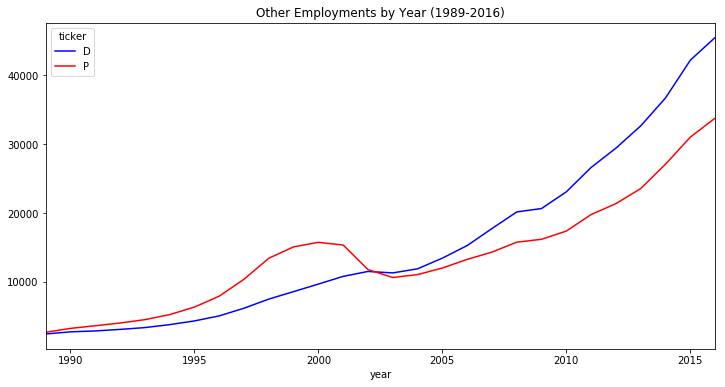

In [11]:
count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
empl_by_years = count_by_years.groupby(['ticker','type']).apply(
    lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
).reset_index(drop=True).pivot_table(
    index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
).assign(
    employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
).drop('cumsum',axis=1).reset_index()
empl_by_years.columns = empl_by_years.columns.droplevel('type')
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Other Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

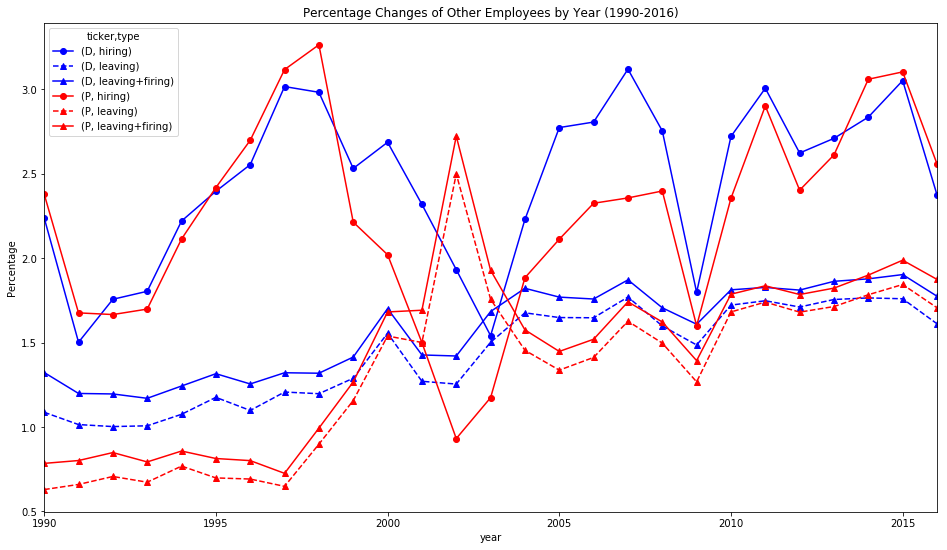

In [12]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# Plot by year.
prop_by_months.pivot_table(
    index = ['ticker','year'], columns = 'type', values = 'prop'
).reset_index().assign(
    **{"leaving+firing":lambda df:(df.leaving+df.firing)}
).pivot_table(
    index='year', columns='ticker', values=['hiring','leaving','leaving+firing']
).reorder_levels(
    ['ticker','type'],axis=1
).sort_index(axis=1).plot(
    style=line_styles, figsize=(16,9), title="Percentage Changes of Other Employees by Year (1990-2016)"
).set_ylabel('Percentage')
plt.show()

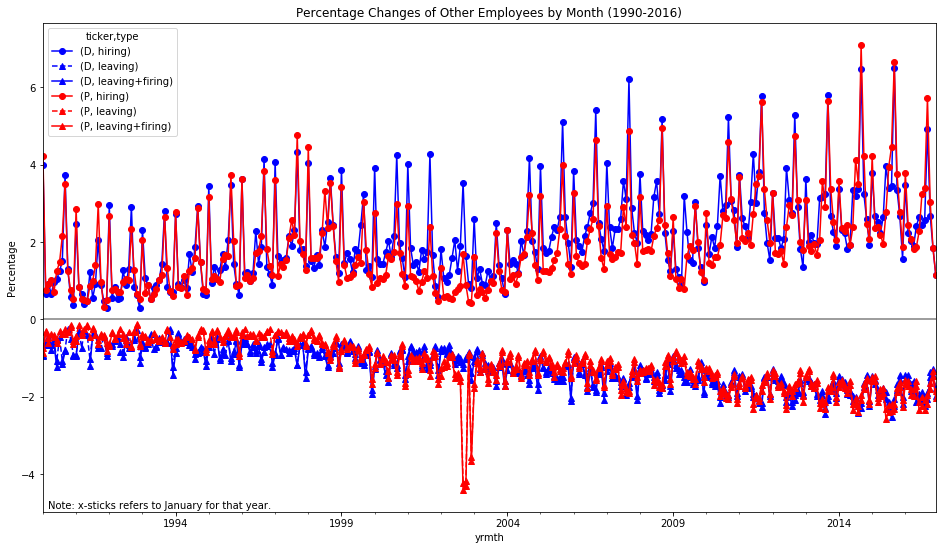

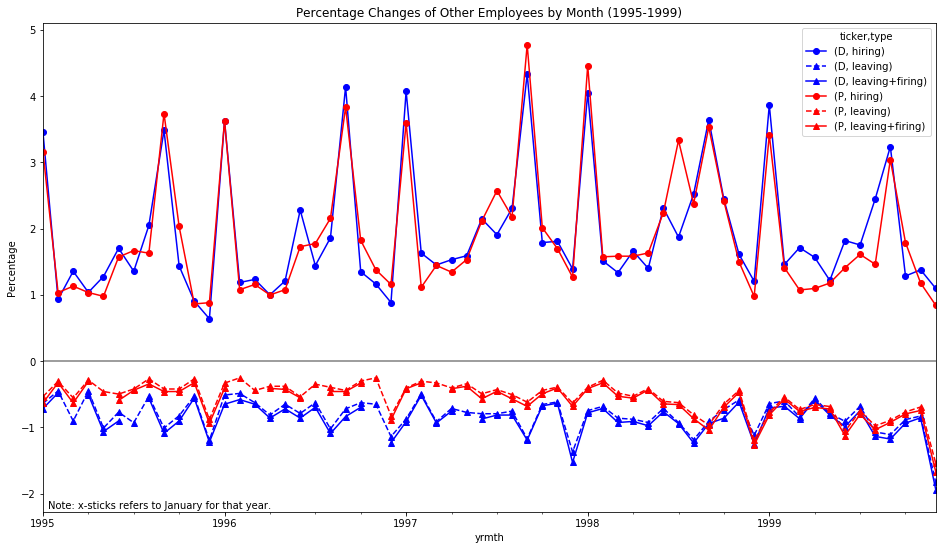

In [13]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=line_styles, figsize=(16,9), 
        title="Percentage Changes of Other Employees by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.

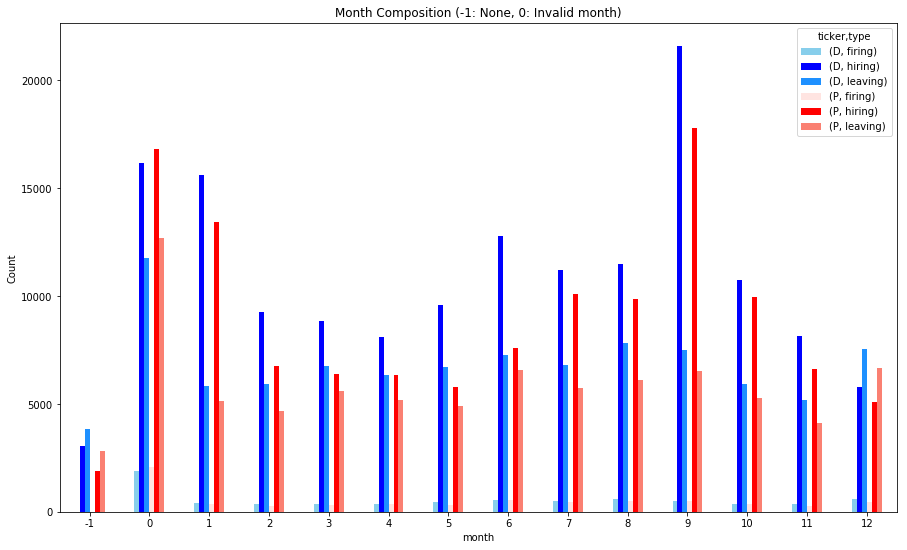

In [14]:
# Month composition.
empl_changes_df.assign(count=1).pivot_table(
    index = 'month', columns = ['ticker','type'], values='count', aggfunc='sum', fill_value=0
).plot.bar(
    figsize=(15,9),color=color_styles,rot=0,
    title="Month Composition (-1: None, 0: Invalid month)"
).set_ylabel("Count")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

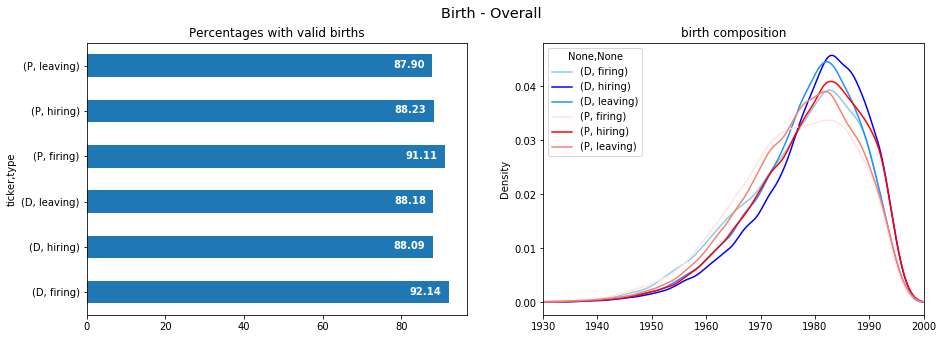

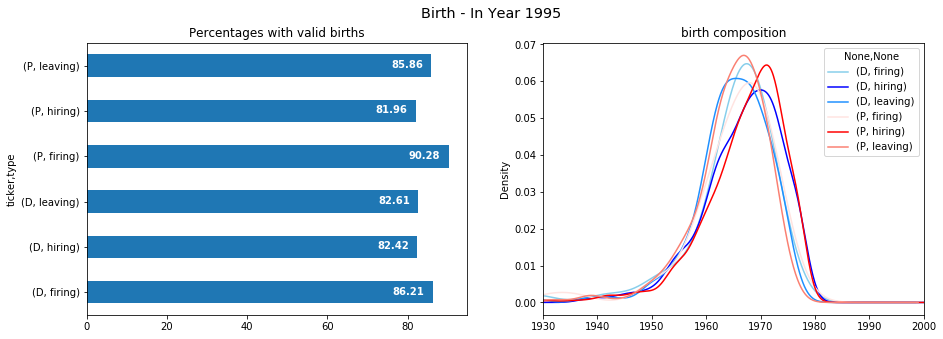

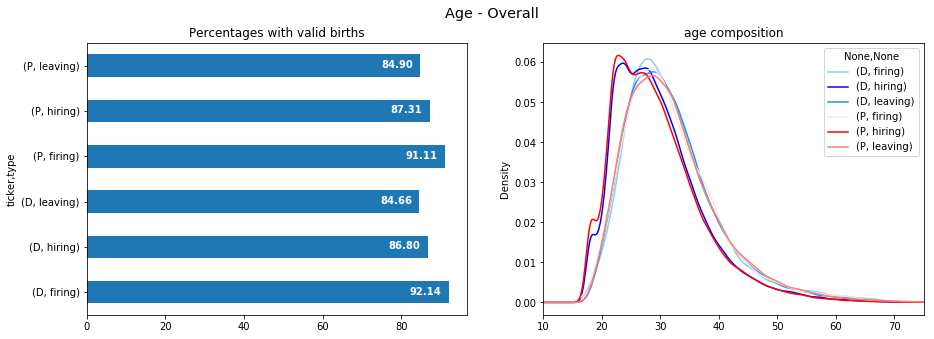

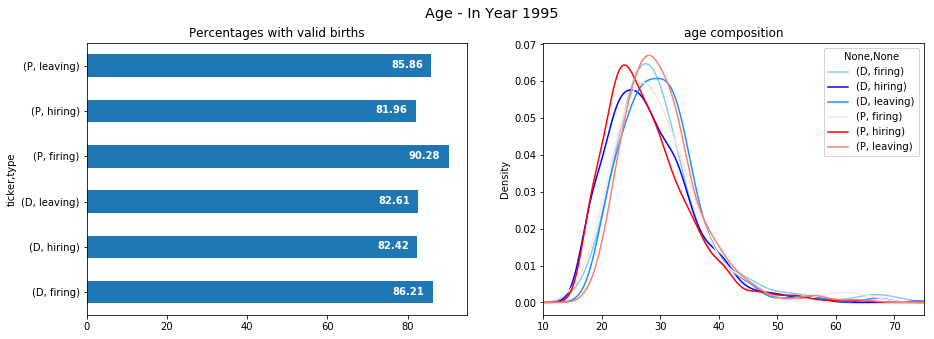

In [15]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

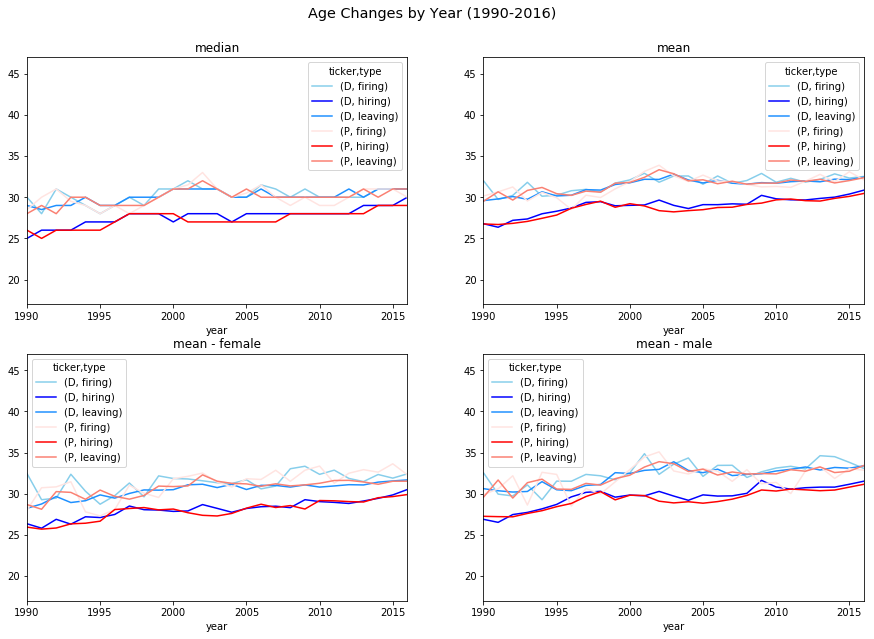

In [16]:
# Age changes by year.
fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Age Changes by Year (1990-2016)',fontsize='x-large',y=0.95)
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
birth_df.loc[empl_changes_df.gender=='1'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
birth_df.loc[empl_changes_df.gender=='2'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
plt.show()

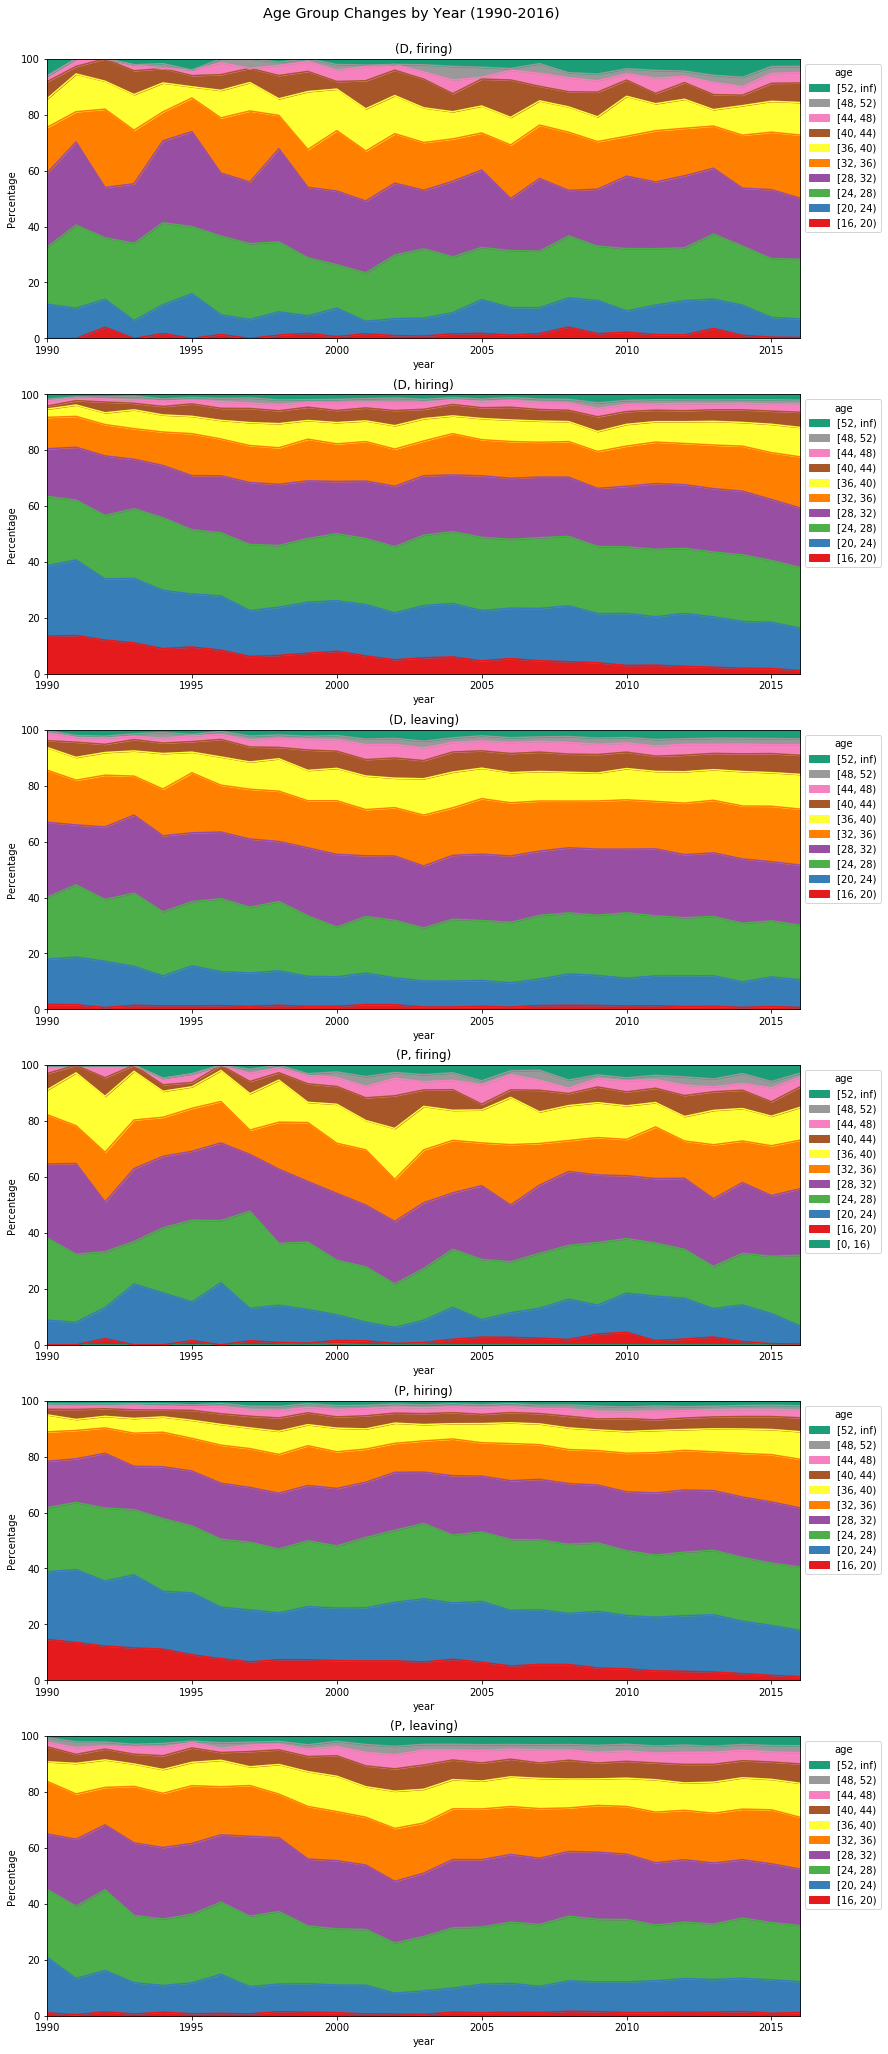

In [17]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

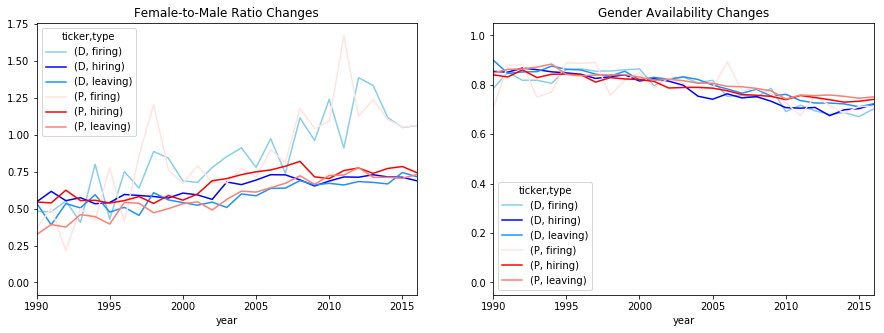

In [18]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2016),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

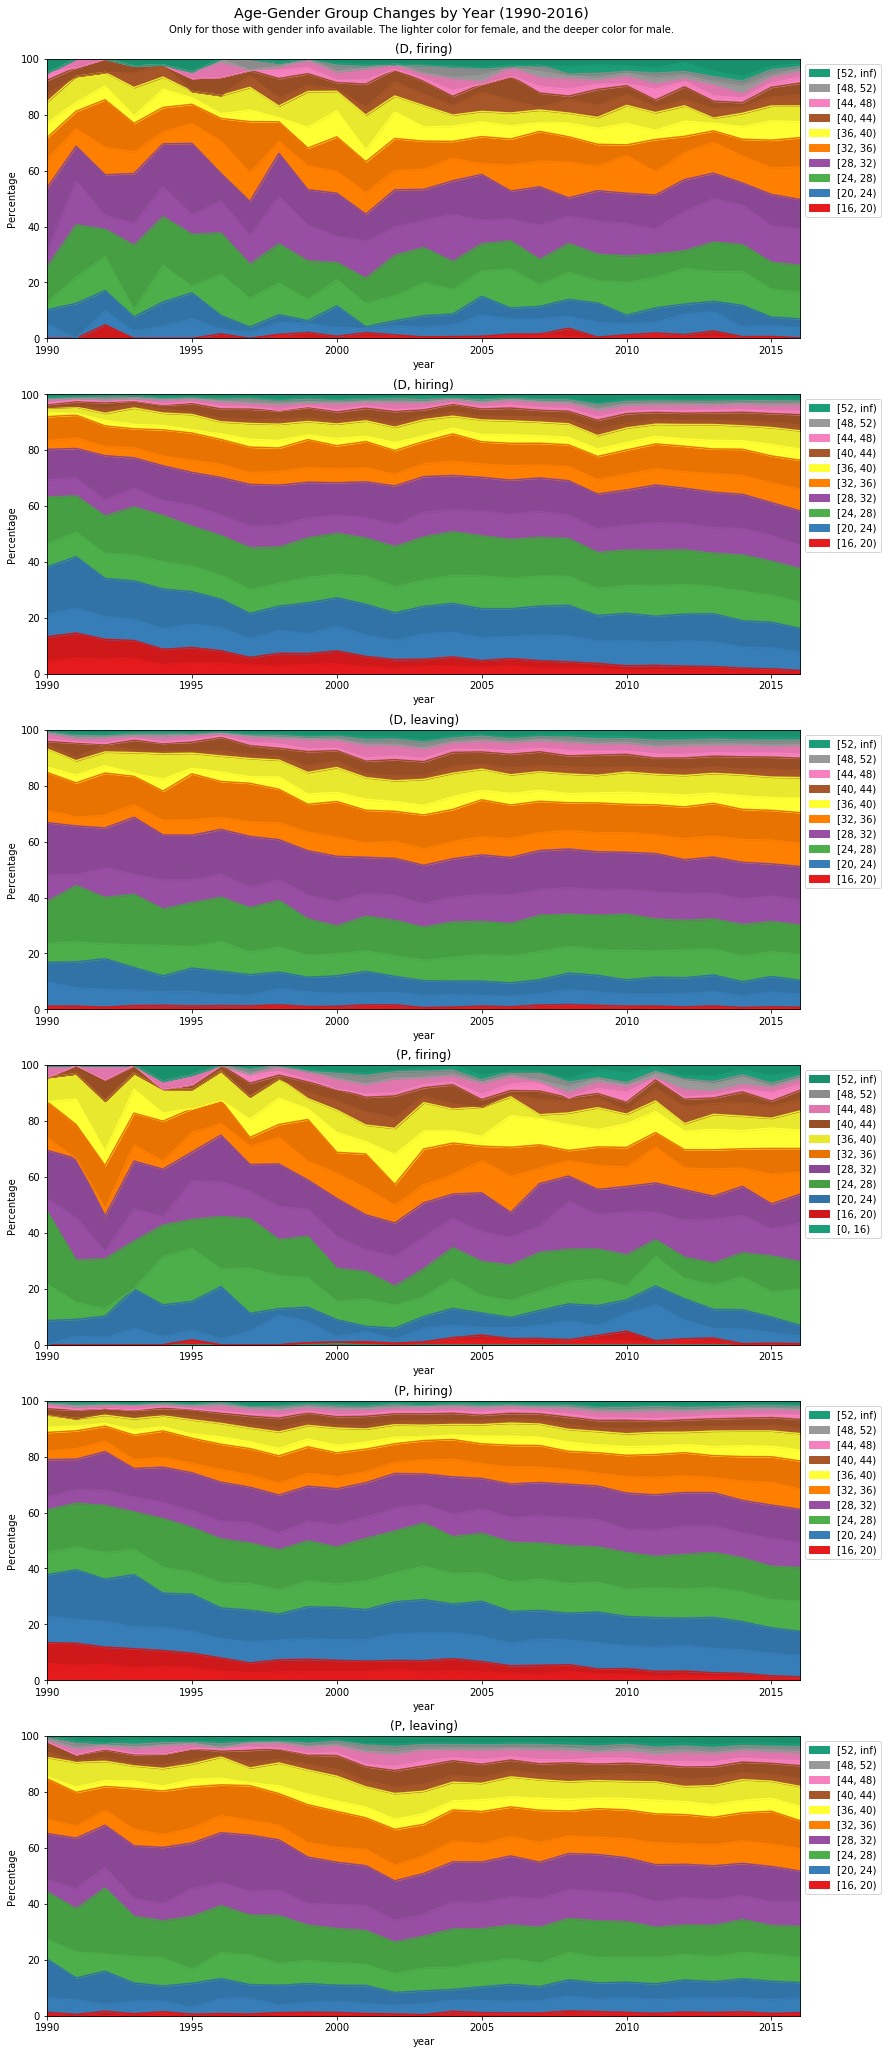

In [19]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.90)
fig.text(0.25,0.89,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

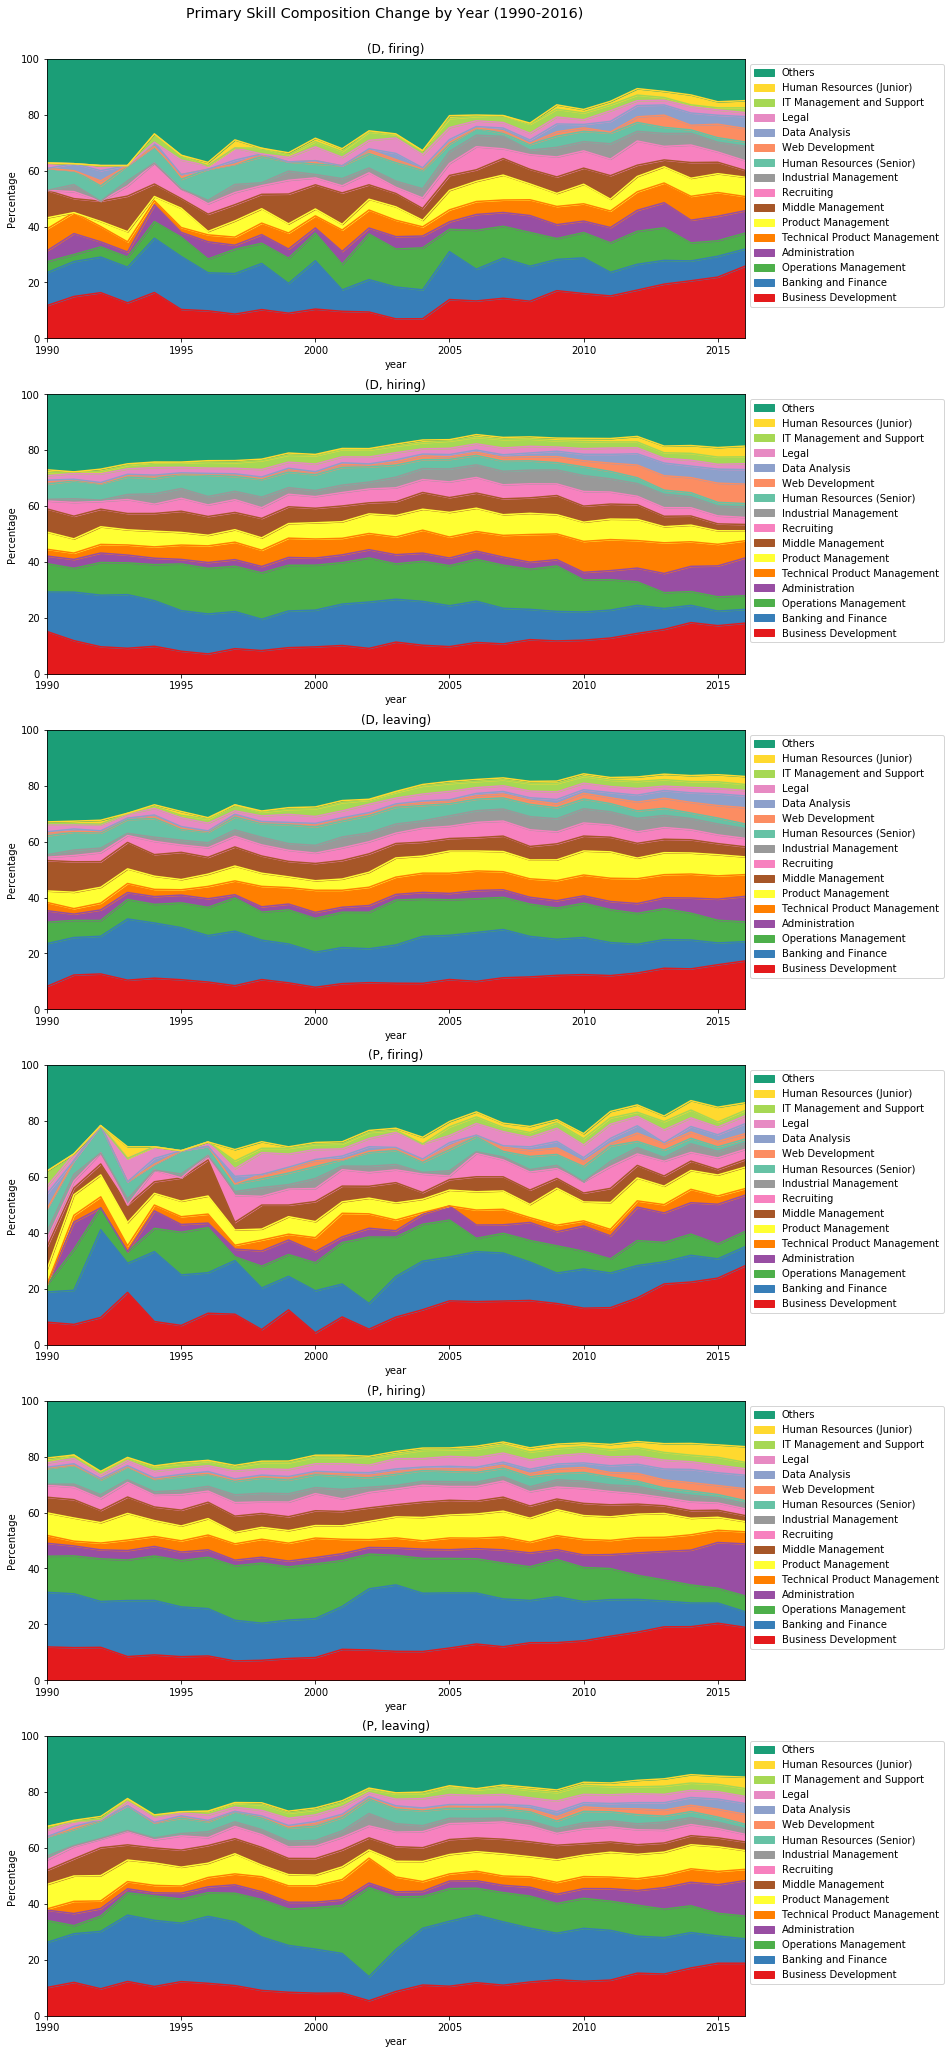

In [20]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill1_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [21]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill1_ord_unif[i]+"</strong>"))
    to_plot = empl_changes_df.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill1==skill1_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30)
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  count  prop       depmt   prop                    edu  \
0         Consultant   2253  3.49  Accounting  46.31              Bachelors   
1            Auditor   1496  2.32    Business  11.59      Masters excl. MBA   
2          Associate   1329  2.06          Hr  10.04           None/Unknown   
3  Senior Consultant   1286  1.99   Oversight   8.75                    MBA   
4            Manager    981  1.52   Marketing   8.12            High school   
5   Senior Associate    837  1.30  Technology   6.55  Doctorate (PhD/JD/MD)   
6            Analyst    824  1.28  Operations   4.68      Vocational degree   
7     Senior Auditor    777  1.20       Legal   2.42             Associates   
8     Tax Consultant    723  1.12  Management   1.25                    NaN   
9   Business Analyst    720  1.12  Production   0.29                    NaN   

    prop  
0  38.94  
1  29.27  
2  16.14  
3   9.90  
4   2.42  
5   1.72  
6   1.53  
7   0.07  
8    NaN  
9    NaN

job_role  \
46682                          Stage Risk Assurance,stage   
29226   Consultant I Venture Architect I Digital Ventu...   
313676            Stagiaire comptable,stagiaire comptable   
75361             Gerente Nacional de Consultoria,gerente   
173430  Project Controller Analyst,project,controller,...   
52756               Assistente Técnico,assistente,técnico   
145719                                Consultor,consultor   
361903                              Assistente,assistente   
68665   Director (Analytics) and Lead Director Analyti...   
337283                                     Risk Assurance   
447238  Tax & Legal services. Tax general. Procedimien...   
439936          Marketing Specialist,marketing specialist   
178958                              Consultant,consultant   
344016                                    Manager,manager   
165355                              Consultant,consultant   
271092                                    Manager,manager   
363246                         Departamento Fiscal,fiscal   
69732   Translator and Interpreter,translator,interpreter   
49989                                       Senior,senior   
424399                                Assistant,assistant   
401494  Senior Associate (high performer),senior assoc...   
124600                 Risk Assurance Associate,associate   
183941               Assistente Contábil Pleno,assistente   
259311                              Consultant,consultant   
383506  Chef de projet MS Dynamics CRM,chef de projet,...   
286104                       Sénior Consultant,consultant   
417495              Analista Fiscal Pleno,analista,fiscal   
130701                                Associate,associate   
259565            Assistant Associate,assistant,associate   
374743             Casual Associate - Assurance,associate   

                                depmt                    edu f_elite  
46682                       OVERSIGHT      Masters excl. MBA   False  
29226                                      Masters excl. MBA   False  
313676                                           High school   False  
75361                                      Masters excl. MBA   False  
173430                                             Bachelors   False  
52756                                              Bachelors   False  
145719                                                   MBA   False  
361903                                     Vocational degree   False  
68665   OPERATIONS,OVERSIGHT,BUSINESS              Bachelors   False  
337283                      OVERSIGHT              Bachelors   False  
447238            HR,ACCOUNTING,LEGAL              Bachelors   False  
439936                      MARKETING              Bachelors   False  
178958                                                   MBA    True  
344016                                          None/Unknown   False  
165355                                     Masters excl. MBA   False  
271092                                          None/Unknown   False  
363246                                     Masters excl. MBA   False  
69732                                  Doctorate (PhD/JD/MD)   False  
49989                                           None/Unknown   False  
424399                                     Masters excl. MBA   False  
401494                                             Bachelors   False  
124600                      OVERSIGHT      Masters excl. MBA   False  
183941                                                   MBA   False  
259311                                             Bachelors   False  
383506                                          None/Unknown   False  
286104                                          None/Unknown   False  
417495                                             Bachelors   False  
130701                                             Bachelors   False  
259565                                     Masters excl. MBA   False  
374743                     

job_role  count  prop       depmt   prop                    edu  \
0            Manager   2978  5.57  Accounting  45.08              Bachelors   
1         Consultant   2313  4.32   Oversight  21.76      Masters excl. MBA   
2   Senior Associate   2060  3.85          Hr  13.27                    MBA   
3  Senior Consultant   1955  3.65    Business  12.02           None/Unknown   
4     Senior Manager   1786  3.34  Operations   3.27  Doctorate (PhD/JD/MD)   
5          Associate   1735  3.24  Technology   2.10            High school   
6            Auditor   1445  2.70   Marketing   1.51      Vocational degree   
7           Director   1058  1.98       Legal   0.60             Associates   
8            Partner    901  1.68  Production   0.21                    NaN   
9  Assistant Manager    852  1.59  Management   0.17                    NaN   

    prop  
0  38.19  
1  25.02  
2  16.82  
3  15.72  
4   3.12  
5   0.74  
6   0.31  
7   0.08  
8    NaN  
9    NaN

job_role          depmt  \
365945                    Partner in UK 1982-2008,partner      OVERSIGHT   
347317  Junior Auditor - Insurance,junior,auditor,insu...     ACCOUNTING   
205652    Assistant Manager - Assurance,assistant manager                  
222703                      Senior Manager,senior manager                  
312091                              Consultant,consultant                  
94884   Wealth Management Tax Services Co-op,managemen...  HR,ACCOUNTING   
131699                  Business Analyst,business analyst                  
202913  Senior Associate | Capital Markets & Accountin...  HR,ACCOUNTING   
320395                                    Auditor,auditor                  
225510        Management Consultant,management consultant                  
315079                Managing Director,managing director      OVERSIGHT   
284402                  Deloitte Skillbuild (6 workshops)                  
189082  Enterprise Risk Services - Analyst,services,an...   HR,OVERSIGHT   
36624                                     Analyst,analyst                  
386346  Associate Audit & Assurance (Co-op),associate,...     ACCOUNTING   
458444        Management Consultant,management consultant                  
299298  Senior Auditor Financial Services Industry,sen...  HR,ACCOUNTING   
186500  Analyst Structured Finance Group,analyst,",",f...     ACCOUNTING   
310813  Associate - Financial Advisory Services,associ...  HR,ACCOUNTING   
77487                                     Analyst,analyst                  
63454                 Human Capital Consultant,consultant                  
154703                      Senior Manager,senior manager                  
394525                      Senior Auditor,senior auditor                  
10388                                         Audit,audit     ACCOUNTING   
250246                  Senior Associate,senior associate                  
364073                      Senior Manager,senior manager                  
205406                        Audit Manager,audit,manager     ACCOUNTING   
258844                      Senior Manager,senior manager                  
14003                   Senior Associate,senior associate                  
105337                       Financial Advisory,financial     ACCOUNTING   

                          edu f_elite  
365945           None/Unknown   False  
347317      Masters excl. MBA   False  
205652      Masters excl. MBA   False  
222703           None/Unknown   False  
312091                    MBA   False  
94884               Bachelors   False  
131699      Masters excl. MBA   False  
202913  Doctorate (PhD/JD/MD)   False  
320395              Bachelors   False  
225510                    MBA   False  
315079           None/Unknown   False  
284402              Bachelors   False  
189082              Bachelors   False  
36624               Bachelors   False  
386346              Bachelors   False  
458444              Bachelors   False  
299298              Bachelors   False  
186500                    MBA    True  
310813              Bachelors    True  
77487               Bachelors   False  
63454               Bachelors   False  
154703              Bachelors   False  
394525              Bachelors   False  
10388       Masters excl. MBA    True  
250246              Bachelors   False  
364073              Bachelors   False  
205406              Bachelors   False  
258844                    MBA   False  
14003               Bachelors   False  
105337              Bachelors   False

job_role  count  prop       depmt   prop  \
0      Senior Consultant   3979  8.24   Oversight  34.01   
1                Manager   3876  8.02  Technology  21.16   
2             Consultant   3715  7.69  Accounting  12.18   
3         Senior Manager   2913  6.03          Hr   9.83   
4               Director   1473  3.05    Business   9.25   
5                Partner    970  2.01  Operations   7.29   
6  Management Consultant    934  1.93   Marketing   4.42   
7   Principal Consultant    928  1.92       Legal   0.76   
8       Senior Associate    516  1.07  Production   0.75   
9        Project Manager    365  0.76  Management   0.35   

                     edu   prop  
0              Bachelors  34.48  
1           None/Unknown  25.39  
2      Masters excl. MBA  20.43  
3                    MBA  15.28  
4  Doctorate (PhD/JD/MD)   2.59  
5            High school   1.26  
6      Vocational degree   0.46  
7             Associates   0.11  
8                    NaN    NaN  
9                    NaN    NaN

job_role  \
183973                Senior Consultant,senior consultant   
32279                       Senior Manager,senior manager   
44879                                     Manager,manager   
439681                                    Partner,partner   
103974                                    Manager,manager   
398704                              Consultant,consultant   
390209                                    Manager,manager   
23827                                      senior manager   
446673          Principal Consultant,principal,consultant   
78191                               Consultant,consultant   
173073              Audit Professional,audit,professional   
148682                              Consultant,consultant   
198064                Senior Consultant,senior consultant   
457308  Risk Assurance Solutions - Financial Service,f...   
311643                   Strategy & Operations,operations   
442334          Principal Consultant,principal,consultant   
351348                                          secretary   
169158  Specialist Leader | Supply Chain & Manufacturi...   
412078  Human Capital Management Consultant,management...   
291817                                    Retired,retired   
360506                                  Proveedor Externo   
21069   Consultant (Strategy & Operations),consultant,...   
132682                                    Manager,manager   
107585                                          Praktikum   
451719                          SAP Consultant,consultant   
292430                  Senior Associate,senior associate   
162869                                    Manager,manager   
103075                                    Partner,partner   
160254  Gerente de Tecnologia e Outsourcing (BPS),gere...   
422425                    Finance Manager,finance manager   

                                          depmt                edu f_elite  
183973                                                None/Unknown   False  
32279                                                    Bachelors   False  
44879                                                    Bachelors   False  
439681                                OVERSIGHT       None/Unknown   False  
103974                                                None/Unknown   False  
398704                                           Masters excl. MBA   False  
390209                                           Masters excl. MBA   False  
23827                                                    Bachelors   False  
446673                                                   Bachelors    True  
78191                                                    Bachelors    True  
173073                               ACCOUNTING  Masters excl. MBA   False  
148682                                                   Bachelors   False  
198064                                                   Bachelors   False  
457308  ACCOUNTING,OVERSIGHT,BUSINESS,MARKETING  Masters excl. MBA   False  
311643                      OPERATIONS,BUSINESS  Masters excl. MBA   False  
442334                                           Masters excl. MBA    True  
351348                                                 High school   False  
169158                    OPERATIONS,PRODUCTION       None/Unknown   False  
412078                                                   Bachelors   False  
291817                                                None/Unknown   False  
360506                                                None/Unknown   False  
21069                       OPERATIONS,BUSINESS          Bachelors    True  
132682                                                None/Unknown   False  
107585                                                None/Unknown   False  
451719                                                         MBA   False  
292430                                           Masters excl. MBA   False  
162869                                                   Bachelors    True  
1

job_role  count  prop       depmt   prop  \
0                 Associate   1236  3.71  Accounting  49.34   
1       Assurance Associate   1190  3.57   Oversight  10.74   
2                Consultant    872  2.62          Hr  10.73   
3       Executive Assistant    760  2.28  Technology  10.15   
4           Audit Associate    541  1.62    Business   7.53   
5          Senior Associate    498  1.50   Marketing   5.09   
6           Audit Assistant    480  1.44  Operations   4.31   
7             Tax Associate    479  1.44       Legal   1.30   
8            Tax Consultant    457  1.37  Production   0.44   
9  Administrative Assistant    418  1.26  Management   0.37   

                     edu   prop  
0              Bachelors  57.11  
1      Masters excl. MBA  17.75  
2           None/Unknown  15.13  
3                    MBA   3.46  
4            High school   3.00  
5      Vocational degree   1.54  
6  Doctorate (PhD/JD/MD)   1.17  
7             Associates   0.83  
8                    NaN    NaN  
9                    NaN    NaN

job_role  \
91002   Executive Personal Assistant,personal assistan...   
150545            Executive Assistant,executive assistant   
34044                                     Manager,manager   
49238   Acting Corportate Hospitality Manager,hospital...   
3531    Executive Assistant (split role with Heddema),...   
56018                                 Associate,associate   
61065   Client Services Team Leader,team leader,client...   
25367      Associate in Risk Assurance Practice,associate   
10962                                     PwC Insight Day   
400892  Senior Consultant Financial Consulting and Fin...   
49620                  Risk Assurance Associate,associate   
108423                             PricewaterhouseCoopers   
15078                 Corporate Receptionist,receptionist   
71830              Assurance & Advisory Summer Vacationer   
145193      Administrative Officer,administrative officer   
117947              Personal Assistant,personal assistant   
455475                  Corporate Tax Analyst,tax,analyst   
438312                        Virtual Assistant,assistant   
279382  Analyst at Consulting department,analyst,consu...   
6356                            Deals Associate,associate   
28837                                 Assistent,assistent   
149833                     Advisory Consultant,consultant   
59485   Software Release Coordinator/Database Administ...   
188993                                Associate,associate   
48204   Senior Administrative Assistant Consulting,adm...   
465396                                    Vac student GRO   
134177      Supplier Administrator,supplier,administrator   
213009                       Advisory Associate,associate   
435205  Associate Insurance and Investment Management,...   
30068             Office Manager (Rapport),office manager   

                      depmt                edu f_elite  
91002                             None/Unknown   False  
150545                       Vocational degree   False  
34044                                Bachelors   False  
49238             MARKETING  Masters excl. MBA   False  
3531                         Vocational degree   False  
56018                                Bachelors    True  
61065          HR,MARKETING          Bachelors   False  
25367             OVERSIGHT          Bachelors   False  
10962                                Bachelors   False  
400892           ACCOUNTING       None/Unknown   False  
49620             OVERSIGHT          Bachelors   False  
108423                               Bachelors   False  
15078              BUSINESS  Vocational degree   False  
71830                        Masters excl. MBA    True  
145193                               Bachelors   False  
117947                            None/Unknown   False  
455475  ACCOUNTING,BUSINESS          Bachelors   False  
438312                       Vocational degree   False  
279382                       Masters excl. MBA   False  
6356                              None/Unknown   False  
28837                             None/Unknown   False  
149833                       Masters excl. MBA   False  
59485            TECHNOLOGY          Bachelors   False  
188993                               Bachelors   False  
48204                             None/Unknown   False  
465396                               Bachelors   False  
134177                            None/Unknown   False  
213009                               Bachelors   False  
435205           ACCOUNTING       None/Unknown   False  
30068                        Vocational degree   False

job_role  count   prop       depmt   prop  \
0                   Consultant   3421  11.63  Technology  45.11   
1            Senior Consultant   2984  10.14    Business  18.02   
2                      Manager   1609   5.47   Oversight   9.01   
3  Business Technology Analyst    912   3.10  Accounting   8.40   
4               Senior Manager    538   1.83          Hr   6.57   
5                      Analyst    476   1.62  Operations   4.82   
6             Senior Associate    383   1.30   Marketing   3.82   
7             Business Analyst    366   1.24  Production   2.58   
8         Principal Consultant    312   1.06       Legal   1.58   
9               Sr. Consultant    225   0.76  Management   0.09   

                     edu   prop  
0              Bachelors  46.71  
1           None/Unknown  20.38  
2      Masters excl. MBA  19.12  
3                    MBA   9.63  
4  Doctorate (PhD/JD/MD)   1.98  
5            High school   1.47  
6      Vocational degree   0.48  
7             Associates   0.23  
8                    NaN    NaN  
9                    NaN    NaN

job_role  \
152998                Senior Consultant,senior consultant   
256053                Senior Consultant,senior consultant   
70117                    Retirement Plans Analyst,analyst   
278776                  Business Analyst,business analyst   
60158                             IT Risk Auditor,auditor   
279002  Consultor SAP MM & WM,consultor,management,war...   
375321                      Senior Manager,senior manager   
370613                                    Manager,manager   
157341                                Associate,associate   
305375                Senior Consultant,senior consultant   
287187  Domain Specialist Microsoft Excel 2013,specialist   
280791          Gerente Senior BI,gerente,senior,business   
214861                                    Manager,manager   
118905                  Operations Staff,operations,staff   
382232                              Consultant,consultant   
423799  Senior Consultant / CFO Services,senior consul...   
158240                Senior Consultant,senior consultant   
171848                      Senior Manager,senior manager   
373956  Senior Software Engineer,senior software engineer   
194350                                    Manager,manager   
61570                    Sr. Consultant,senior,consultant   
295596                              Consultant,consultant   
60564                    Salesforce Consultant,consultant   
433355      Senior Solutions Specialist,senior,specialist   
459306                              Consultant,consultant   
78933                 Senior Consultant,senior consultant   
343078                              Consultant,consultant   
177293   Technology Manager / Architect,manager,architect   
7315                        Senior Manager,senior manager   
228342             Director knowledge management,director   

                       depmt                    edu f_elite  
152998                                    Bachelors   False  
256053                                    Bachelors   False  
70117                                     Bachelors   False  
278776                                    Bachelors   False  
60158   TECHNOLOGY,OVERSIGHT              Bachelors   False  
279002                                 None/Unknown   False  
375321                        Doctorate (PhD/JD/MD)   False  
370613                                    Bachelors   False  
157341                                    Bachelors   False  
305375                                    Bachelors   False  
287187                            Masters excl. MBA   False  
280791              BUSINESS            High school   False  
214861                                    Bachelors   False  
118905            OPERATIONS              Bachelors   False  
382232                                          MBA   False  
423799                    HR           None/Unknown   False  
158240                                    Bachelors   False  
171848                                 None/Unknown   False  
373956            TECHNOLOGY           None/Unknown   False  
194350                                    Bachelors   False  
61570                                  None/Unknown   False  
295596                            Masters excl. MBA   False  
60564                             Masters excl. MBA   False  
433355              BUSINESS      Masters excl. MBA   False  
459306                                    Bachelors   False  
78933                                           MBA   False  
343078                                 None/Unknown   False  
177293            TECHNOLOGY              Bachelors   False  
7315                                   None/Unknown   False  
228342             OVERSIGHT      Masters excl. MBA   False

## By Secondary Skill.

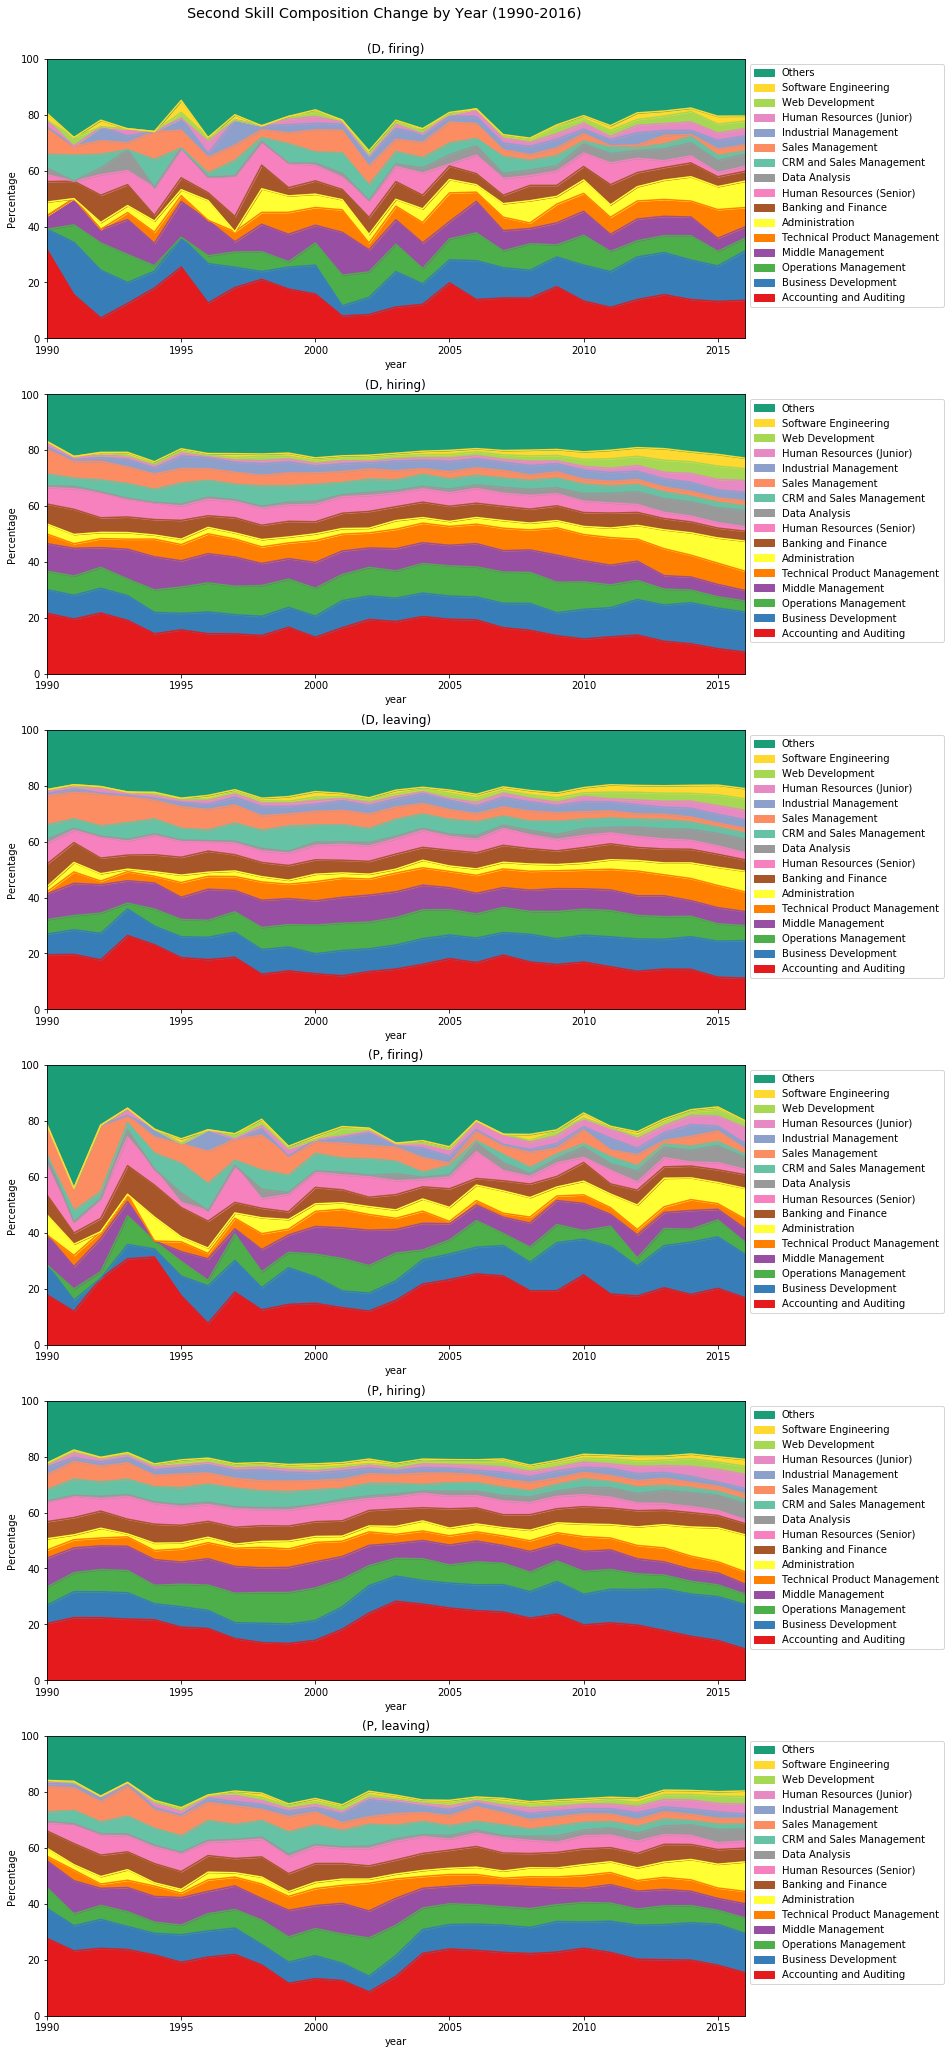

In [22]:
skill2_to_plot = empl_changes_df.loc[lambda df:df.skill2!='']

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill2_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [23]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  count  prop       depmt   prop                    edu  \
0            Manager   2042  3.59  Accounting  58.96              Bachelors   
1            Auditor   1912  3.36   Oversight  16.00      Masters excl. MBA   
2   Senior Associate   1808  3.18          Hr  11.21           None/Unknown   
3          Associate   1457  2.56    Business   5.98                    MBA   
4         Consultant   1434  2.52  Technology   3.53  Doctorate (PhD/JD/MD)   
5  Senior Consultant   1409  2.48  Operations   1.87            High school   
6     Senior Manager   1402  2.46   Marketing   1.41      Vocational degree   
7     Senior Auditor   1330  2.34       Legal   0.82             Associates   
8       Audit Senior    810  1.42  Management   0.12                    NaN   
9  Assistant Manager    748  1.32  Production   0.11                    NaN   

    prop  
0  45.60  
1  23.86  
2  15.49  
3  10.19  
4   2.75  
5   1.31  
6   0.69  
7   0.11  
8    NaN  
9    NaN

job_role  \
373864                                     Senior Manager   
5297                                    Assistant Auditor   
28936                                          Consultant   
222469                                            Auditor   
307112                                         Consultant   
123207               Senior Consultant Consulting Finance   
313573                          Departamento de Auditoría   
221834                                   Senior Associate   
34674                                            Auditeur   
95362          Financial & Risk Advisory - Winter Analyst   
460395                        Business Technology Analyst   
360545                                     Senior Auditor   
361177                                            Partner   
407295                                Assurance Associate   
461999                                            Auditor   
354653                                  Senior Consultant   
278811                                         Consultant   
129377                  Student then Qualified Accountant   
326726                            Risk Advisory Assurance   
318470                                     Senior Manager   
272088                                    Risk Consultant   
111467                                    Audit Assistant   
146935                                        Tax Analyst   
420000  Director-Corporate Finance Financial Advisory ...   
101762                               Gerente de impuestos   
25197           Audit Manager (Financial Institute Group)   
121813                                          associate   
243698                                    Audit Associate   
142502     Financial Advisory-Forensic/ Senior Consultant   
372715                                       Audit Senior   

                       depmt                edu f_elite  
373864                             None/Unknown   False  
5297                               None/Unknown   False  
28936                                 Bachelors   False  
222469                                Bachelors   False  
307112                        Masters excl. MBA   False  
123207            ACCOUNTING  Masters excl. MBA   False  
313573                                Bachelors   False  
221834                                Bachelors   False  
34674                              None/Unknown   False  
95362   ACCOUNTING,OVERSIGHT          Bachelors    True  
460395            TECHNOLOGY                MBA   False  
360545                                Bachelors   False  
361177             OVERSIGHT          Bachelors   False  
407295                                      MBA   False  
461999                        Masters excl. MBA   False  
354653                        Masters excl. MBA   False  
278811                        Masters excl. MBA   False  
129377                                Bachelors   False  
326726             OVERSIGHT       None/Unknown   False  
318470                                Bachelors   False  
272088             OVERSIGHT  Masters excl. MBA   False  
111467            ACCOUNTING          Bachelors   False  
146935            ACCOUNTING  Masters excl. MBA   False  
420000  ACCOUNTING,MARKETING  Masters excl. MBA   False  
101762                                Bachelors   False  
25197             ACCOUNTING          Bachelors    True  
121813                        Masters excl. MBA   False  
243698            ACCOUNTING  Vocational degree   False  
142502            ACCOUNTING       None/Unknown   False  
372715            ACCOUNTING          Bachelors   False

job_role  count  prop       depmt   prop                    edu  \
0         Consultant   1853  4.40  Accounting  35.46              Bachelors   
1  Senior Consultant   1083  2.57    Business  14.16      Masters excl. MBA   
2          Associate    834  1.98          Hr  11.81           None/Unknown   
3            Auditor    755  1.79   Oversight  10.16                    MBA   
4            Manager    715  1.70  Technology   9.59  Doctorate (PhD/JD/MD)   
5            Analyst    626  1.49   Marketing   8.94            High school   
6   Business Analyst    483  1.15  Operations   5.90      Vocational degree   
7   Senior Associate    433  1.03       Legal   2.31             Associates   
8    Audit Assistant    377  0.90  Management   1.40                    NaN   
9     Tax Consultant    361  0.86  Production   0.27                    NaN   

    prop  
0  40.68  
1  28.48  
2  14.71  
3  10.73  
4   2.12  
5   1.90  
6   1.27  
7   0.11  
8    NaN  
9    NaN

job_role  \
161151                              Stage de fin d’études   
19504                                           Associate   
450308          Governance Risk & Compliance - Consultant   
321717                                 Auditor Financiero   
461244                                     Senior Analyst   
170334                               Assistant Consultant   
148197         Business Technology Analyst Summer Scholar   
31801                                     Analista Junior   
359323                                       Audit Senior   
215355                               Assistant of Auditor   
229647  Consultant and auditor of indirect taxes and g...   
381078                                          Auditoría   
196870                                Business Consultant   
105770                                        Semi-Senior   
166101  Manager Cyber RIsks and Cyber Crisis Managemen...   
438152                                          Assistant   
444947                               Process Specialist B   
244736                                     IT- Consultant   
115868                                            Gerente   
318151                                         Consultant   
425757             Associate: Banking and Capital Markets   
383058                              Staff de contabilidad   
314162                  Consultor Data Analytics - Senior   
312969                                            Abogado   
119478                               Research/Job Analyst   
218738                        Business Technology Analyst   
404621                          Gerente Legal Corporativo   
143546                                   Staff Core Audit   
200857                                           Analista   
441066  International Business Developer - Swedish Mar...   

                       depmt                edu f_elite  
161151                             None/Unknown   False  
19504                         Masters excl. MBA    True  
450308  OPERATIONS,OVERSIGHT                MBA   False  
321717                                Bachelors   False  
461244                                Bachelors   False  
170334                        Masters excl. MBA   False  
148197            TECHNOLOGY  Masters excl. MBA   False  
31801                                       MBA   False  
359323            ACCOUNTING          Bachelors   False  
215355                        Masters excl. MBA   False  
229647                                Bachelors   False  
381078                                      MBA   False  
196870                                      MBA   False  
105770                                Bachelors   False  
166101                             None/Unknown   False  
438152                                Bachelors   False  
444947                                Bachelors   False  
244736                             None/Unknown   False  
115868                                Bachelors   False  
318151                                Bachelors   False  
425757            ACCOUNTING          Bachelors    True  
383058                                Bachelors   False  
314162              BUSINESS          Bachelors   False  
312969                                Bachelors   False  
119478                                      MBA   False  
218738            TECHNOLOGY          Bachelors   False  
404621                 LEGAL  Masters excl. MBA   False  
143546            ACCOUNTING  Masters excl. MBA   False  
200857                        Masters excl. MBA   False  
441066              BUSINESS  Masters excl. MBA   False

job_role  count  prop       depmt   prop  \
0      Senior Consultant   2154  8.35   Oversight  27.03   
1             Consultant   1925  7.46  Technology  21.48   
2                Manager   1907  7.39    Business  11.13   
3         Senior Manager   1138  4.41  Accounting  11.06   
4               Director    521  2.02          Hr  11.00   
5  Management Consultant    449  1.74  Operations  10.38   
6   Principal Consultant    372  1.44   Marketing   5.18   
7                Partner    316  1.23       Legal   1.19   
8       Senior Associate    271  1.05  Production   0.87   
9       Business Analyst    247  0.96  Management   0.69   

                     edu   prop  
0              Bachelors  37.50  
1           None/Unknown  22.05  
2      Masters excl. MBA  20.08  
3                    MBA  15.22  
4  Doctorate (PhD/JD/MD)   2.84  
5            High school   1.43  
6      Vocational degree   0.77  
7             Associates   0.11  
8                    NaN    NaN  
9                    NaN    NaN

job_role  \
51908                               Lead Business Analyst   
448313          Senior ECM consultant (datacap / Filenet)   
301579                                            Manager   
54421                                         Associate 7   
281275  Leader and Head - Working Capital Competency G...   
115355                              Consultant Technology   
6793                    Participant - Big Sail Adventures   
184456                                 Revisionsassistent   
134791           Advisory Marketing Management Consulting   
64542                                    Manager QliKView   
163300                                    Project Manager   
199185                                            Manager   
236999                  Associate Risk Assurance Services   
59436                                 Managing Consultant   
38597                                   Assistant Manager   
359956                                   Business Analyst   
179735                             Human Capital Advisory   
426801                                  Senior Consultant   
124695                                Managing Consultant   
65008   IT Portfolio Management/CPIC - Management Cons...   
302200                                     Senior Manager   
24219                                            Director   
229611  Assistant Manager Architect and Security Exper...   
20237                               Asistente de Advisory   
234400                                     Senior Manager   
102320            Auditor (who can't help consulting....)   
212170                                  Associate Manager   
215135                   Strategy & Operations Consultant   
353833                      Manager Strategy & Operations   
27147                               Manager CyberSecurity   

                        depmt                edu f_elite  
51908                               None/Unknown   False  
448313                              None/Unknown   False  
301579                                 Bachelors   False  
54421                                  Bachelors   False  
281275                                       MBA   False  
115355             TECHNOLOGY  Masters excl. MBA   False  
6793                                 High school   False  
184456                              None/Unknown   False  
134791              MARKETING       None/Unknown   False  
64542                               None/Unknown   False  
163300                                 Bachelors   False  
199185                         Masters excl. MBA    True  
236999           HR,OVERSIGHT          Bachelors    True  
59436                                  Bachelors    True  
38597                          Masters excl. MBA   False  
359956                              None/Unknown   False  
179735                                 Bachelors   False  
426801                                 Bachelors   False  
124695                                       MBA   False  
65008              TECHNOLOGY          Bachelors   False  
302200                                 Bachelors   False  
24219               OVERSIGHT       None/Unknown   False  
229611  OPERATIONS,TECHNOLOGY  Masters excl. MBA   False  
20237                                  Bachelors   False  
234400                                       MBA   False  
102320                         Masters excl. MBA   False  
212170                         Masters excl. MBA   False  
215135    OPERATIONS,BUSINESS                MBA   False  
353833    OPERATIONS,BUSINESS          Bachelors    True  
27147                               None/Unknown   False

job_role  count  prop       depmt   prop  \
0      Senior Consultant   1569  6.54   Oversight  20.18   
1             Consultant   1550  6.46  Accounting  18.36   
2                Manager   1278  5.33          Hr  15.94   
3         Senior Manager    817  3.41  Technology  13.18   
4       Senior Associate    426  1.78    Business  13.17   
5               Director    380  1.58  Operations   9.67   
6  Management Consultant    378  1.58   Marketing   5.88   
7                Analyst    334  1.39       Legal   1.48   
8                Auditor    297  1.24  Management   1.31   
9              Associate    286  1.19  Production   0.82   

                     edu   prop  
0              Bachelors  38.05  
1      Masters excl. MBA  20.20  
2                    MBA  19.45  
3           None/Unknown  16.41  
4  Doctorate (PhD/JD/MD)   3.52  
5            High school   1.28  
6      Vocational degree   0.83  
7             Associates   0.28  
8                    NaN    NaN  
9                    NaN    NaN

job_role                    depmt  \
329005                                 Principal                            
450177            Transaction Services - Analyst                       HR   
227990           Senior Manager - Atlanta office                            
171636        Senior Client Relationship Manager                            
441372                                      Lead                            
362030                                Consulting                            
111835            Senior Analyst-IT Service Desk                MARKETING   
53040                          Assistant Manager                            
434224                                consultant                            
101103         Senior Manager Financial Services            HR,ACCOUNTING   
429718                            Senior Manager                            
401819                 SAP HR/Payroll Consultant                            
352520             Associate Consultant/ Analyst                            
161602                          Senior Associate                            
226655                 Client Services IT Leader  HR,MARKETING,TECHNOLOGY   
55445   Senior Analyst-Travel & Related Services                       HR   
429504                           Audit Associate               ACCOUNTING   
63900          Consultante Senior Secteur public                            
213377                        Consultant Analyst                            
375715               Business Technology Analyst               TECHNOLOGY   
365896                         Specialist Senior                            
360886                          Senior Associate                            
78325                          Senior Consultant                            
302074                                  Director                OVERSIGHT   
207067                                HR Advisor                       HR   
317873                         Senior Consultant                            
281963      Senior Manager Strategy & Operations      OPERATIONS,BUSINESS   
342693                          Senior Associate                            
132895          Analyst Human Capital Consulting                            
175115        Project Team Leader - DESC Project                            

                          edu f_elite  
329005                    MBA   False  
450177      Masters excl. MBA   False  
227990                    MBA    True  
171636              Bachelors   False  
441372                    MBA   False  
362030  Doctorate (PhD/JD/MD)   False  
111835              Bachelors   False  
53040               Bachelors   False  
434224              Bachelors   False  
101103      Masters excl. MBA   False  
429718                    MBA    True  
401819              Bachelors   False  
352520  Doctorate (PhD/JD/MD)   False  
161602                    MBA   False  
226655           None/Unknown   False  
55445               Bachelors   False  
429504              Bachelors   False  
63900                     MBA    True  
213377      Masters excl. MBA   False  
375715                    MBA   False  
365896              Bachelors   False  
360886              Bachelors   False  
78325               Bachelors   False  
302074              Bachelors   False  
207067      Masters excl. MBA   False  
317873                    MBA    True  
281963           None/Unknown   False  
342693              Bachelors   False  
132895      Masters excl. MBA   False  
175115              Bachelors   False

job_role  count  prop       depmt   prop  \
0                   Consultant   2081  9.32  Technology  43.49   
1            Senior Consultant   1782  7.98    Business  13.52   
2                      Manager   1127  5.05   Oversight  12.40   
3  Business Technology Analyst    534  2.39  Accounting   9.11   
4               Senior Manager    507  2.27          Hr   7.02   
5                      Analyst    330  1.48  Operations   5.19   
6         Principal Consultant    264  1.18   Marketing   4.10   
7             Senior Associate    236  1.06  Production   3.60   
8             Business Analyst    218  0.98       Legal   1.38   
9                    Associate    178  0.80  Management   0.19   

                     edu   prop  
0              Bachelors  44.97  
1      Masters excl. MBA  20.62  
2           None/Unknown  19.71  
3                    MBA  10.30  
4  Doctorate (PhD/JD/MD)   1.83  
5            High school   1.56  
6      Vocational degree   0.75  
7             Associates   0.26  
8                    NaN    NaN  
9                    NaN    NaN

job_role  \
1234                                       Senior Manager   
77167                                       Data Engineer   
290063                                     SAP Consultant   
74603                                            Director   
131016                       Salesforce Senior Consultant   
168168                                  Senior Consultant   
47122                                         Sr. Manager   
181507                                  SAP FI Consultant   
77306                        Senior Sharepoint Consultant   
434922                                       Specialist 4   
427309                        Business Technology Analyst   
122769                                         Consultant   
337630                                         IT Auditor   
112806                              Strategy & Operations   
252918  Executive Assistant to Two Partners & General ...   
453397                                IT Security Manager   
163921                   Senior Manager Advisory Services   
99920   Product Development Manager Contracted via The...   
163699                                       IT Executive   
77967                                           Principal   
19897                                       Web Developer   
97943                               Advisor Public Sector   
96243                    Manager - Information Management   
201996                                 BTA Summer Scholar   
431024                     Senior Digital Project Manager   
251100                           Senior Software Engineer   
54057                             Senior Research Analyst   
67586                                Helpdesk Coordinator   
380116                                   Center Associate   
8442                                              Manager   

                        depmt                    edu f_elite  
1234                                       Bachelors   False  
77167                              Masters excl. MBA   False  
290063                                     Bachelors   False  
74603               OVERSIGHT           None/Unknown   False  
131016                                     Bachelors   False  
168168                                   High school   False  
47122                                      Bachelors   False  
181507                                           MBA   False  
77306                              Masters excl. MBA   False  
434922                                     Bachelors   False  
427309             TECHNOLOGY  Doctorate (PhD/JD/MD)   False  
122769                                  None/Unknown   False  
337630             TECHNOLOGY              Bachelors   False  
112806    OPERATIONS,BUSINESS              Bachelors   False  
252918                                  None/Unknown   False  
453397  OPERATIONS,TECHNOLOGY              Bachelors   False  
163921                     HR              Bachelors   False  
99920                                      Bachelors   False  
163699             TECHNOLOGY              Bachelors   False  
77967                                            MBA   False  
19897              TECHNOLOGY              Bachelors   False  
97943                              Masters excl. MBA   False  
96243                                   None/Unknown   False  
201996                                     Bachelors   False  
431024                                           MBA   False  
251100             TECHNOLOGY           None/Unknown   False  
54057              TECHNOLOGY           None/Unknown   False  
67586                                      Bachelors   False  
380116                                  None/Unknown   False  
8442                                    None/Unknown   False

## By Country.

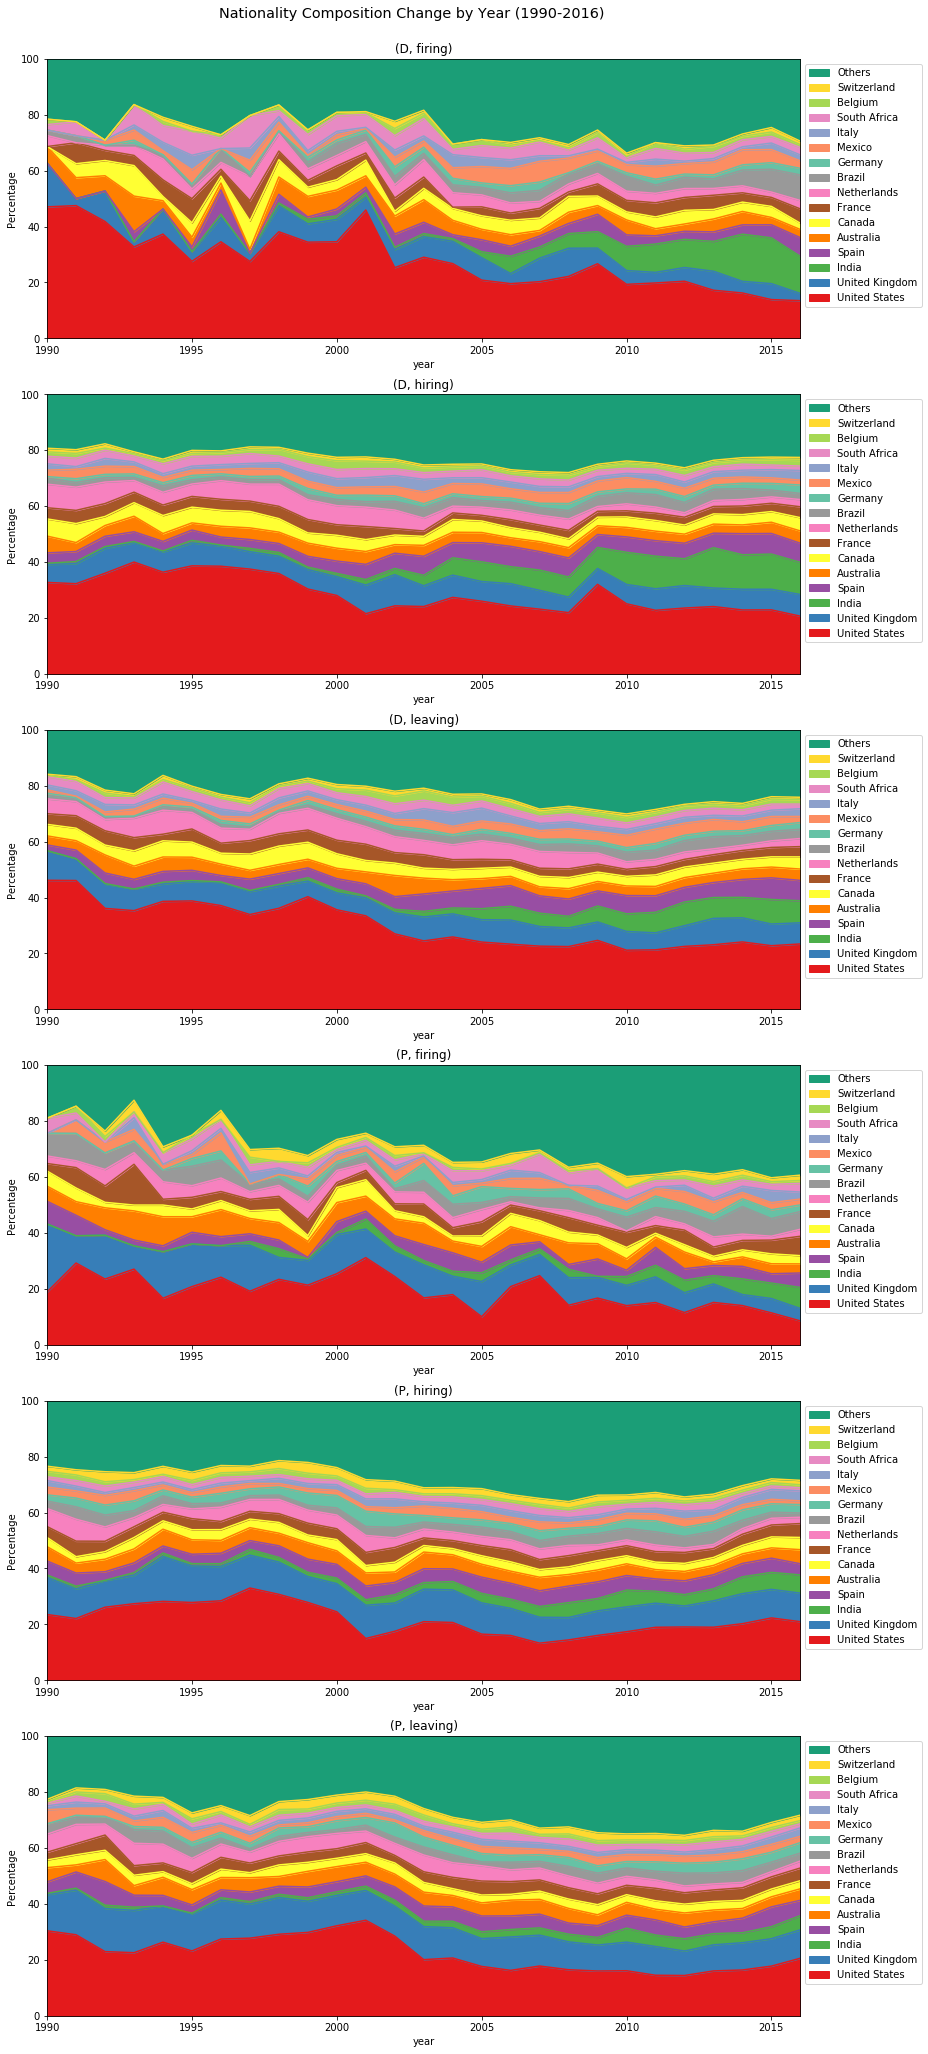

In [24]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

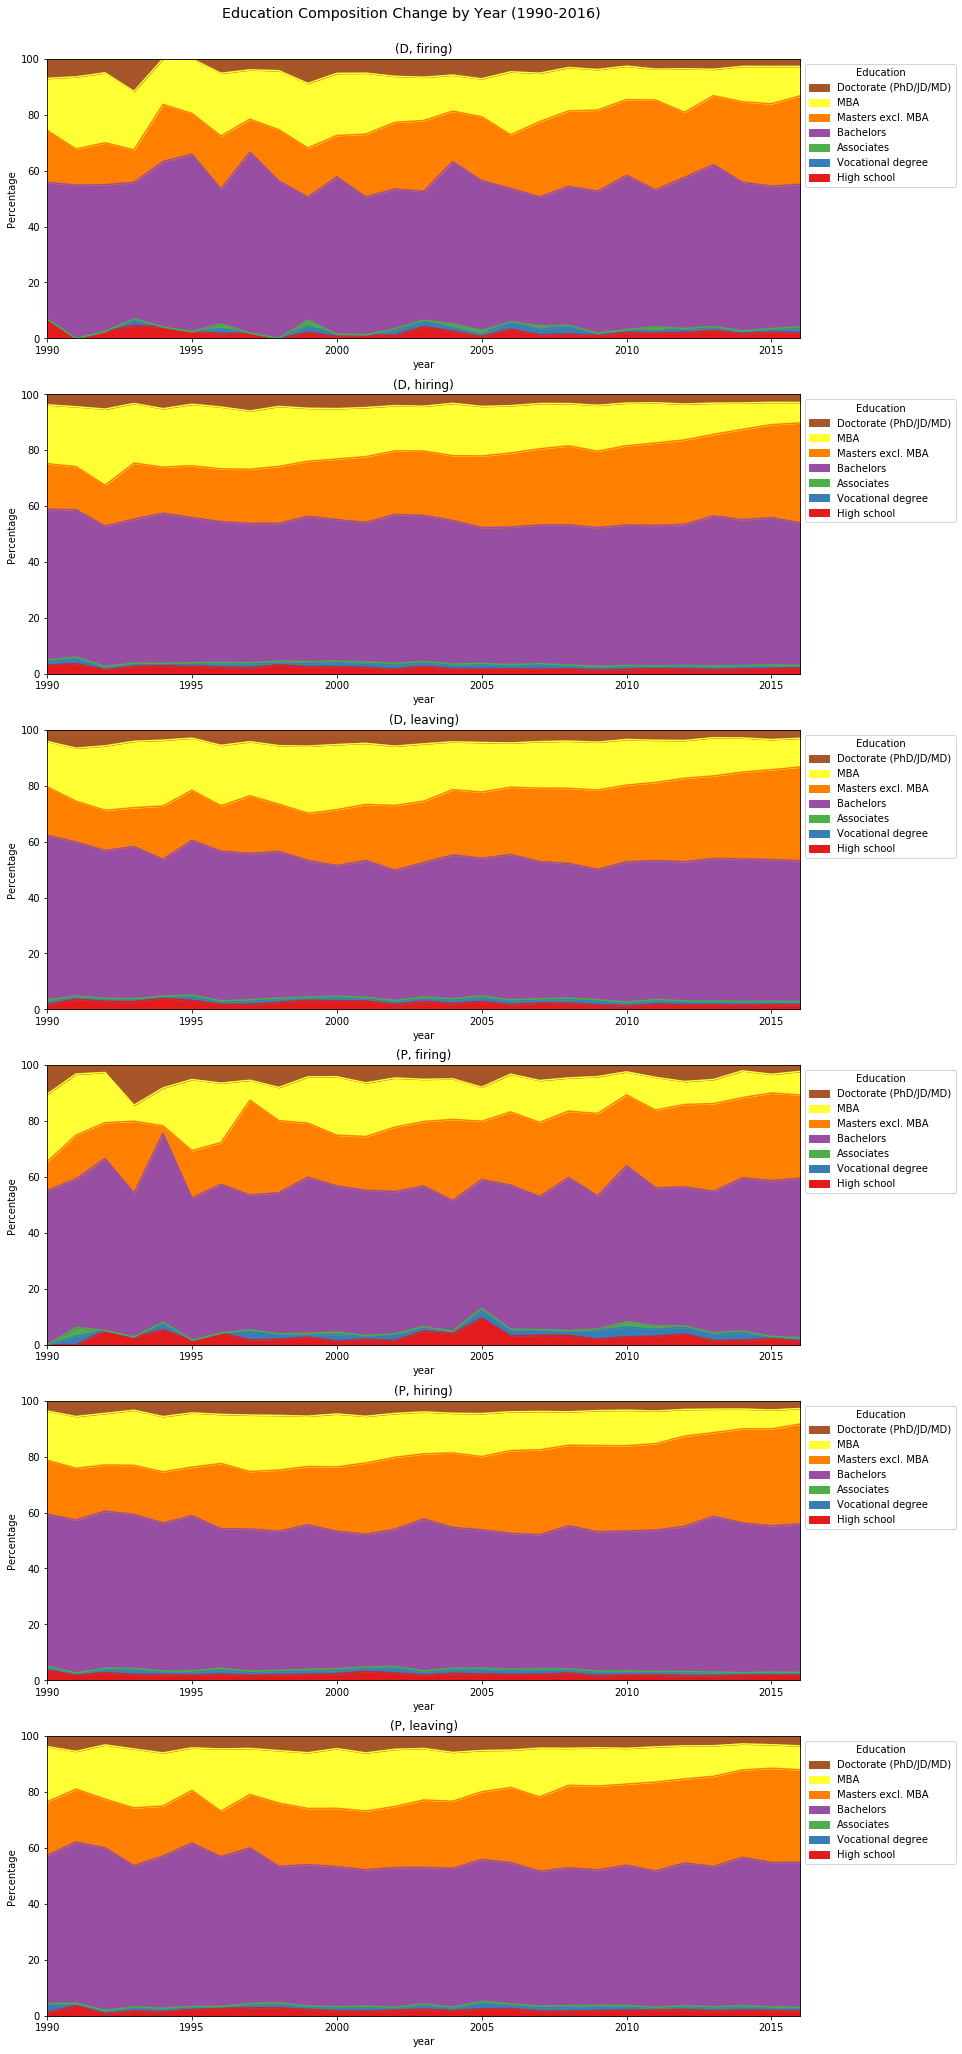

In [25]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



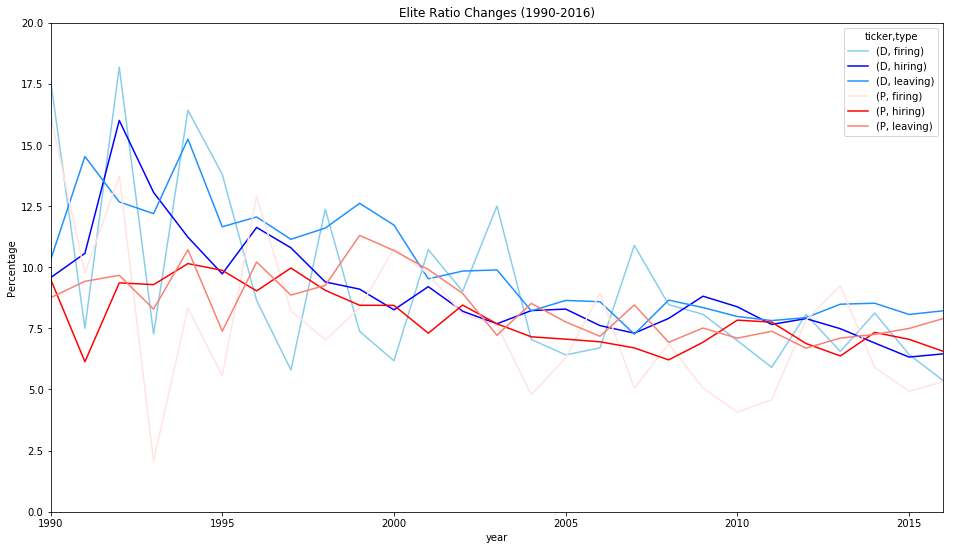

In [26]:
ax = empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='f_elite',
    aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
).plot(
    xlim=(1990,2016),ylim=(0,20),color=color_styles,
    title="Elite Ratio Changes (1990-2016)",figsize=(16,9)
)
ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [27]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Industry group                  NAICS2
0           Natural Resources and Mining                  11, 21
1                           Construction                      23
2                          Manufacturing              31, 32, 33
3   Trade, Transportation, and Utilities  42, 44, 45, 48, 49, 22
4                            Information                      51
5                   Financial Activities                  52, 53
6     Professional and Business Services              54, 55, 56
7          Education and Health Services                  61, 62
8                Leisure and Hospitality                  71, 72
9                         Other Services                      81
10                 Public Administration                      92
11                  Unknown/Unclassified            99, , MI, 46

Note: `46` seems to be a wrong NAICS2 code.

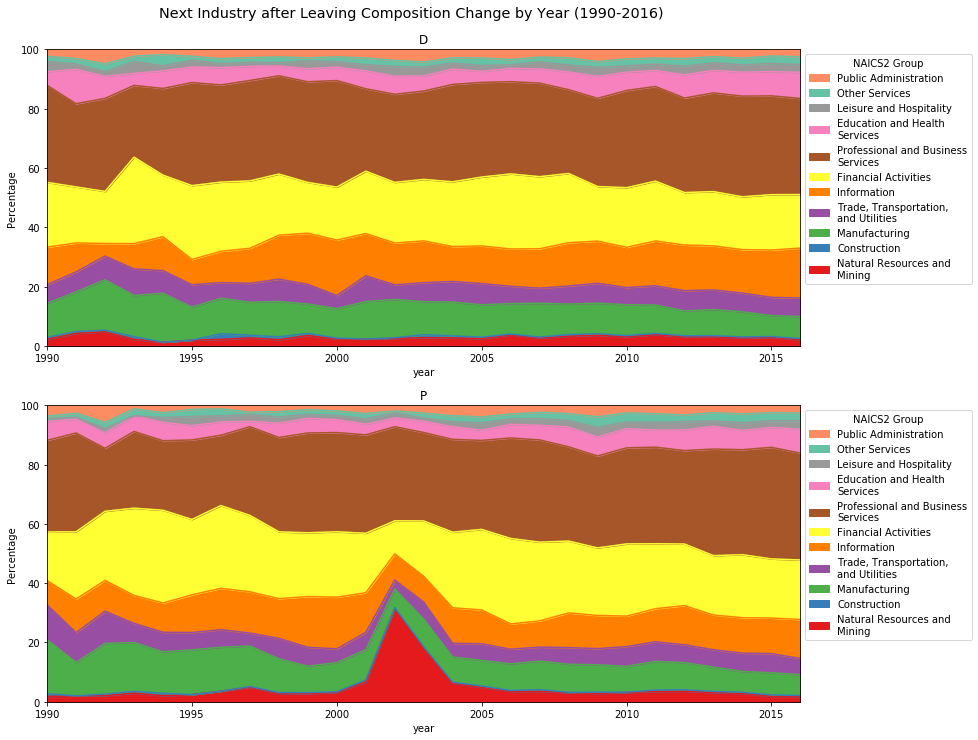

In [28]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

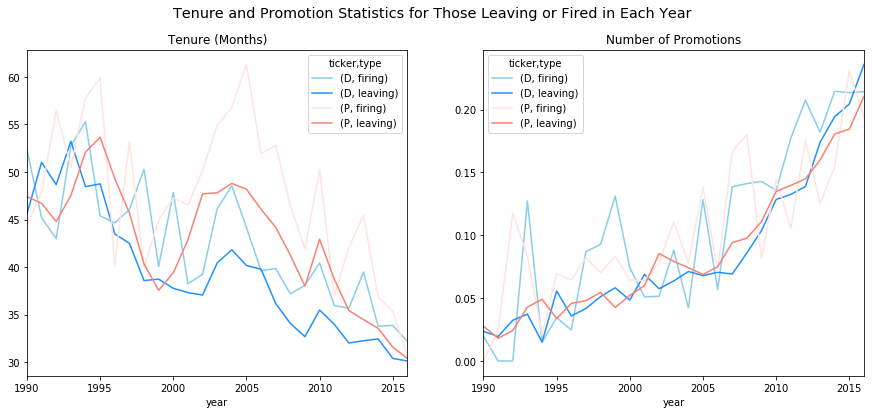

In [29]:
# Calculate.
to_plot = empl_changes_df.loc[lambda df:(df.type!='hiring')&(df.year>=1990)&(df.year<=2016)].astype(
    {'tenure':'Int64','nprom':'Int64'}
).pivot_table(
    columns=['ticker','type'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
)

# Plot.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
to_plot['tenure'].plot(
    title="Tenure (Months)", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax1
)
to_plot['nprom'].plot(
    title="Number of Promotions", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax2
)
plt.show()